##Generator, Discriminator and GAN model##

In [ ]:
# example of training a conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


  # define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
  # gan_output from d_model loss
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
  



**Image generator (Image loading, real image, fake image)**

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

  # use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

Training


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# noise generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>90, 149/468, d1=0.634, d2=0.672 g=0.798
>90, 150/468, d1=0.688, d2=0.655 g=0.790
>90, 151/468, d1=0.734, d2=0.670 g=0.786
>90, 152/468, d1=0.728, d2=0.682 g=0.763
>90, 153/468, d1=0.689, d2=0.692 g=0.765
>90, 154/468, d1=0.713, d2=0.678 g=0.783
>90, 155/468, d1=0.728, d2=0.665 g=0.758
>90, 156/468, d1=0.730, d2=0.674 g=0.760
>90, 157/468, d1=0.671, d2=0.691 g=0.755
>90, 158/468, d1=0.670, d2=0.675 g=0.777
>90, 159/468, d1=0.705, d2=0.644 g=0.779
>90, 160/468, d1=0.681, d2=0.661 g=0.773
>90, 161/468, d1=0.660, d2=0.703 g=0.780
>90, 162/468, d1=0.690, d2=0.685 g=0.777
>90, 163/468, d1=0.699, d2=0.668 g=0.776
>90, 164/468, d1=0.687, d2=0.713 g=0.809
>90, 165/468, d1=0.728, d2=0.681 g=0.757
>90, 166/468, d1=0.650, d2=0.667 g=0.768
>90, 167/468, d1=0.683, d2=0.669 g=0.780
>90, 168/468, d1=0.663, d2=0.690 g=0.764
>90, 169/468, d1=0.674, d2=0.672 g=0.755
>90, 170/468, d1=0.679, d2=0.682 g=0.759
>90, 171/468, d1=0.704, d2=0.628 g=0.767
>90, 1

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import tensorflow as tf
import os
import glob
from google.colab import drive
import difflib

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

# t-shirt, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot

In [ ]:
cat=input("Enter Clothe Category")
print(cat)

Enter Clothe Categorybag
bag


In [ ]:
 cutoff=70
 labl=np.array([0]*20)
 from fuzzywuzzy import fuzz
 from fuzzywuzzy import process
 if (fuzz.token_set_ratio((cat), "T-Shirt")) > cutoff:
   labl[0]=fuzz.token_set_ratio((cat), "T-Shirt")
 elif(fuzz.token_set_ratio((cat), "top")) > cutoff:
    labl[1]=fuzz.token_set_ratio((cat), "top" ) 
 elif(fuzz.token_set_ratio((cat), "trouser")) > cutoff:
    labl[2]=fuzz.token_set_ratio((cat), "trouser")
 elif(fuzz.token_set_ratio((cat), "Pullover")) > cutoff:
    labl[3]=fuzz.token_set_ratio((cat), "Pullover")
 elif(fuzz.token_set_ratio((cat), "Dress")) > cutoff:
    labl[4]=fuzz.token_set_ratio((cat), "Dress")
 elif(fuzz.token_set_ratio((cat), "Coat")) > cutoff:
    labl[5]=fuzz.token_set_ratio((cat), "Coat")
 elif(fuzz.token_set_ratio((cat), "Sandal")) > cutoff:
    labl[6]=fuzz.token_set_ratio((cat), "Sandal")
 elif(fuzz.token_set_ratio((cat), "Shirt")) > cutoff:
    labl[7]=fuzz.token_set_ratio((cat), "Shirt")     
 elif(fuzz.token_set_ratio((cat), "Sneaker")) > cutoff:
    labl[8]=fuzz.token_set_ratio((cat), "Sneaker")
 elif(fuzz.token_set_ratio((cat), "Bag")) > cutoff:
    labl[9]=fuzz.token_set_ratio((cat), "Bag")
 elif(fuzz.token_set_ratio((cat), "Ankle Boot")) > cutoff:
    labl[10]=fuzz.token_set_ratio((cat), "Ankle Boot") 
 else:
      labl[10]=int(fuzz.token_set_ratio((cat), "Ankle Boot") )
      print("No match") 
print(labl)
result = np.where(labl == np.amax(labl))
print(result[0])
if result[0]==0:
  lb=0
if result[0]==1:
  lb=0
if result[0]==2:
  lb=1
if result[0]==3:
  lb=2
if result[0]==4:
  lb=3
if result[0]==5:
  lb=4
if result[0]==6:
  lb=5
if result[0]==7:
  lb=6
if result[0]==8:
  lb=7
if result[0]==9:
  lb=8              
if result[0]==10:
  lb=9
print (lb)
  

[  0   0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0
   0   0]
[9]
8


Actual Image


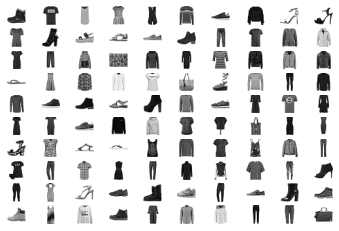

In [ ]:
# example of loading the generator model and generating images
from keras.datasets.fashion_mnist import load_data
from numpy import expand_dims
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
  
#print(labels)
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
#labels = asarray([x for _ in range(10) for x in range(10)])
#labels=asarray([2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2])
labels=np.full(shape=100,fill_value=lb,dtype=np.int)

#generate real images
print("Actual Image")
(trainX, trainy), (_, _) = load_data()
# expand to 3d, e.g. add channels
X1 = expand_dims(trainX, axis=-1)
# convert from ints to floats
X1 = X1.astype('float32')
# scale from [0,255] to [-1,1]
X1 = (X1 - 127.5) / 127.5
#print(trainy)
save_plot(X1, 10)






Generated image


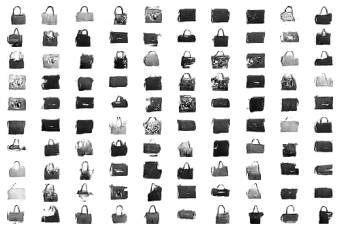

In [ ]:
# generate images
print("Generated image")
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)
#print (labels)
#print(X)
